#### CS20M059 Shibobrota Das | CS20M007 Abhishek Kumar

## Setup

In [1]:
!pip install tensorflow-addons -qqq

     |████████████████████████████████| 686kB 9.2MB/s eta 0:00:01


In [2]:
!pip install wandb -qqq

     |████████████████████████████████| 1.8MB 8.4MB/s 
     |████████████████████████████████| 133kB 51.7MB/s 
     |████████████████████████████████| 174kB 38.2MB/s 
     |████████████████████████████████| 102kB 12.8MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 


In [15]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import GradientTape
from tensorflow import keras
import pandas as pd
import datetime
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, GRU, SimpleRNN, SimpleRNNCell, LSTMCell, GRUCell
from keras.models import Sequential
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
import time
import sys
import datetime
from sklearn.utils import shuffle
import wandb
# import nltk
import csv
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties

print("Using numpy:",np.__version__)
print("Using tensorflow:",tf.__version__)
print("Using tensorflow Addons:",tfa.__version__)
print("Using keras:",keras.__version__)
print("Using pandas:",pd.__version__)

Using numpy: 1.19.5
Using tensorflow: 2.5.0
Using tensorflow Addons: 0.13.0
Using keras: 2.5.0
Using pandas: 1.2.4


In [ ]:
# wandb.init(project='Assignment 3', entity='iitm-cs6910-jan-may-2021-cs20m059-cs20m007')

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/DL-A3 Dataset/dakshina_dataset_v1.0/hi/'

Mounted at /content/drive
/content/drive/My Drive/DL-A3 Dataset/dakshina_dataset_v1.0/hi


#### Load Data

In [16]:
val_df = pd.read_csv("./lexicons/hi.translit.sampled.dev.tsv", sep='\t', header=None)
train_df = pd.read_csv("./lexicons/hi.translit.sampled.train.tsv", sep='\t', header=None)
test_df = pd.read_csv("./lexicons/hi.translit.sampled.test.tsv", sep='\t', header=None)
print("Data Loaded to Dataframes!")

Data Loaded to Dataframes!


In [6]:
%cd '/content/drive/My Drive/A3-checkpoints/'

/content/drive/My Drive/A3-checkpoints


#### Dataset Samples

In [17]:
train_df.sample(n=3)

,0,1,2
33464,राजीव,rajiv,4
5639,एतिहासिक,athihasik,1
7565,कामयाब,kamyab,4


## Preparing Dataset

In [18]:
sos = "@"
eos = "#"

In [19]:
class LexDataset:
    def __init__(self, input_tensor, target_tensor, batch_size):
        self.input_tensor = input_tensor
        self.target_tensor = target_tensor
        self.batch = tf.data.Dataset.from_tensor_slices((self.input_tensor, self.target_tensor)).shuffle(len(self.input_tensor)).batch(batch_size, drop_remainder=True)

In [69]:
class TransliterationDatatset:
    def __init__(self, df_list, batch_size = 64):
        
        self.input_tokenizer = None
        self.target_tokenizer = None
        self.train = None
        self.val = None
        self.test = None
        self.batch_size = batch_size
        # Load Data
        self.load_dataset(df_list)
        # Other parameters
        self.num_input_tokens = len(self.input_tokenizer.index_word)+1
        self.num_target_tokens = len(self.target_tokenizer.index_word)+1
        self.max_input_seq_length = np.max([self.train.input_tensor.shape[1], self.val.input_tensor.shape[1], self.test.input_tensor.shape[1]])
        self.max_target_seq_length = np.max([self.train.target_tensor.shape[1], self.val.target_tensor.shape[1], self.test.target_tensor.shape[1]])
        
    def preprocess_word(self, w):
        return sos + str(w) + eos
    
    def print_input(self, tensor):
        for t in tensor:
            if t != 0:
                print(f'{t} ----> {self.input_tokenizer.index_word[t]}')
                
    def print_target(self, tensor):
        for t in tensor:
            if t != 0:
                print(f'{t} ----> {self.target_tokenizer.index_word[t]}')
    
    def create_dataset(self, data_frame):
        input_words = []
        target_words = []
        # Shuffle the data_frame before creating dataset
        df = data_frame
        for i in range(5):
            df = shuffle(df)
        for x, y in zip(df[1], df[0]):
            input_words.append(self.preprocess_word(x))
            target_words.append(self.preprocess_word(y))
        return (input_words, target_words)
    
    def load_dataset(self, df_list):
        # df_list should have train -> val -> test in sequence
        
        self.input_tokenizer = Tokenizer(num_words = None, char_level = True)
        self.target_tokenizer = Tokenizer(num_words = None, char_level = True)
        
        ds_list = []
        
        for df in df_list:
            # Get the words list
            (input_words, target_words) = self.create_dataset(df)
            # Fit on the set of words
            self.input_tokenizer.fit_on_texts(input_words)
            self.target_tokenizer.fit_on_texts(target_words)
            ds_list.append((input_words, target_words))
                    
        self.target_tokenizer.index_word.update({0:" "})
        self.input_tokenizer.index_word.update({0:" "})
        
        input_word_len = []
        target_word_len = []
        
        tensor_list = []
        
        for i, (input_words, target_words) in enumerate(ds_list):
            input_tensor = self.input_tokenizer.texts_to_sequences(input_words)
            target_tensor = self.target_tokenizer.texts_to_sequences(target_words)
            tensor_list.append((input_tensor, target_tensor))
            input_word_len.append(np.max([len(x) for x in input_tensor]))
            target_word_len.append(np.max([len(x) for x in target_tensor]))
        
        for i, (input_tensor, target_tensor) in enumerate(tensor_list):
            
            input_tensor = pad_sequences(input_tensor, padding='post', maxlen = np.max(input_word_len))
            target_tensor = pad_sequences(target_tensor, padding='post', maxlen = np.max(target_word_len))
            
            if i == 0:
                self.train = LexDataset(input_tensor, target_tensor, self.batch_size)
            elif i == 1:
                self.val = LexDataset(input_tensor, target_tensor, self.batch_size)
            else:
                self.test = LexDataset(input_tensor, target_tensor, self.batch_size)

In [70]:
dataset = TransliterationDatatset([train_df, val_df, test_df], 128)

#### Training Data

In [71]:
# Training data
dataset.train.input_tensor.shape, dataset.train.target_tensor.shape

((44204, 22), (44204, 21))

#### Validation Data

In [72]:
# Validation data
dataset.val.input_tensor.shape, dataset.val.target_tensor.shape

((4358, 22), (4358, 21))

#### Test Data

In [73]:
# Test data
dataset.test.input_tensor.shape, dataset.test.target_tensor.shape

((4502, 22), (4502, 21))

#### Number of Tokens

In [74]:
# Number of tokens
dataset.num_input_tokens, dataset.num_target_tokens

(30, 67)

#### Maximum Sequence Lengths

In [75]:
# max seq length
dataset.max_input_seq_length, dataset.max_target_seq_length

(22, 21)

#### Example batch - dataset

In [76]:
example_input_batch, example_target_batch = next(iter(dataset.train.batch))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 22]), TensorShape([128, 21]))

In [77]:
dataset.print_input(example_input_batch[2].numpy())

2 ----> @
9 ----> s
1 ----> a
7 ----> r
20 ----> v
1 ----> a
12 ----> d
16 ----> m
4 ----> n
3 ----> #


In [78]:
dataset.print_target(example_target_batch[2].numpy())

1 ----> @
9 ----> स
4 ----> र
5 ----> ्
16 ----> व
20 ----> द
15 ----> म
6 ----> न
2 ----> #


## Encoder and Decoder Model

In [79]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz, layer_type="GRU"):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
#         if layer_type == "LSTM":
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [80]:
vocab_inp_size = dataset.num_input_tokens
embedding_dim = 64
units = 256
BATCH_SIZE = dataset.batch_size

In [81]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units)', sample_output.shape)
print('Encoder Hidden state shape: (batch size, units)', sample_hidden.shape)

Encoder output shape: (batch size, sequence length, units) (128, 22, 256)
Encoder Hidden state shape: (batch size, units) (128, 256)


In [107]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [108]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units)", attention_result.shape)
print("Attention weights shape: (batch_size, sequence_length, 1)", attention_weights.shape)

Attention result shape: (batch size, units) (128, 256)
Attention weights shape: (batch_size, sequence_length, 1) (128, 22, 1)


In [109]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [110]:
vocab_tar_size = dataset.num_target_tokens

In [111]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print('Decoder output shape: (batch_size, vocab size)', sample_decoder_output.shape)

Decoder output shape: (batch_size, vocab size) (128, 67)


## Optimizer and the loss function

In [112]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [113]:
def word_accuracy(real, pred):
    pass

## Training

In [114]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([dataset.target_tokenizer.word_index[sos]] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [115]:
EPOCHS = 1
steps_per_epoch = len(dataset.train.input_tensor)//BATCH_SIZE

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.train.batch.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')

    print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.4508
Epoch 1 Batch 100 Loss 0.9377
Epoch 1 Batch 200 Loss 0.8829
Epoch 1 Batch 300 Loss 0.7952
Epoch 1 Loss 0.9113
Time taken for 1 epoch 587.46 sec



## Translate

In [116]:
def evaluate(sentence):
    attention_plot = np.zeros((dataset.max_target_seq_length, dataset.max_input_seq_length))

    sentence = dataset.preprocess_word(sentence)

    inputs = [dataset.input_tokenizer.word_index[i] for i in sentence]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=dataset.max_input_seq_length,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([dataset.target_tokenizer.word_index[sos]], 0)

    for t in range(dataset.max_target_seq_length):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                            dec_hidden,
                                                            enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += dataset.target_tokenizer.index_word[predicted_id]

        if dataset.target_tokenizer.index_word[predicted_id] == eos:
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [117]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    hindi_font = FontProperties(fname = 'Nirmala.ttf')

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=0)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties=hindi_font)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    input = ''.join([ch for ch in sentence])[1:-1]
    target = ''.join([ch for ch in predicted_sentence])[:-1]
    plt.title(f"Input: {input}  Prediction: {target}", fontproperties=hindi_font, fontsize = 20)
    plt.savefig(f"{input}.png")
    plt.show()

In [118]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input:', sentence)
    print('Predicted translation:', result)

    attention_plot = attention_plot[:len(result),
                                  :len(sentence)]
    plot_attention(attention_plot, [i for i in sentence], [i for i in result])

Input: @lol#
Predicted translation: लिल#


<ipython-input-117-d5b7a9cdfa81>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=0)
<ipython-input-117-d5b7a9cdfa81>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties=hindi_font)


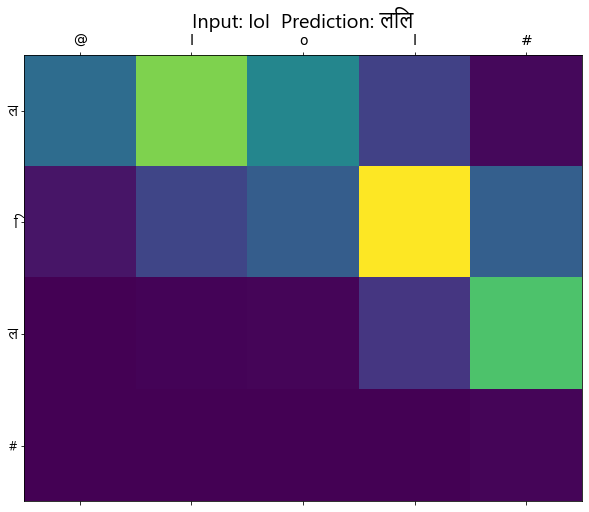

In [125]:
translate("lol")

In [ ]:
sequence = dataset.input_tokenizer.texts_to_sequences("shibobrota")
np.reshape(sequence, len(sequence))

array([ 9,  6,  5, 19, 11, 19,  7, 11,  8,  1])

In [ ]:
text = dataset.input_tokenizer.sequences_to_texts(sequence)
text

['s', 'h', 'i', 'b', 'o', 'b', 'r', 'o', 't', 'a']

In [41]:
def save_predictions(data_frame, name):
    accuracy_count = 0;
    with open(name, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["INPUT", "PREDICTION", "TRUE"])
        for i, (inp, trg) in enumerate(zip(data_frame[1], data_frame[0])): 
            result, sentence, attention_plot = evaluate(inp)
            writer.writerow([inp, result[:-1], trg])
            print(inp, result[:-1], trg)
            if result[:-1] == trg:
                accuracy_count += 1
            if (i+1) % 100 == 0 or i+1 == data_frame.size:
                print("Accuracy", (accuracy_count / (i+1)))

    return accuracy_count/data_frame.size

In [ ]:
save_predictions(test_df, "new_without_attn_predictions.csv")